In [101]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

train_path = "/app/duy55/segmentation/annotation/train_sorted.csv"
train_df = pd.read_csv(train_path)

val_path = "/app/duy55/segmentation/annotation/val_sorted.csv"
val_df = pd.read_csv(train_path)

class ImageLoader:
    
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            sample[key] = cv2.imread(sample[key])
            if key == 'masks' and len(sample[key].shape) > 2:
                sample[key] = cv2.cvtColor(sample[key], cv2.COLOR_BGR2GRAY)
        return sample

In [82]:
image_loader = ImageLoader(['images', 'masks'])
sample = image_loader(train_df.iloc[0])

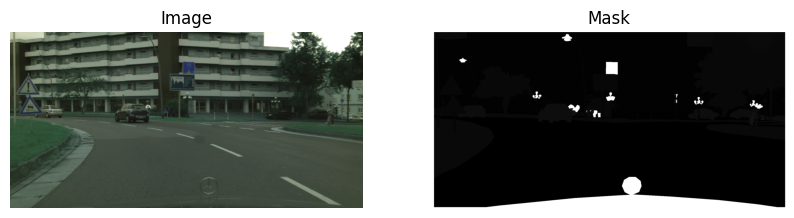

In [12]:
image = sample['images']
mask = sample['masks']

# # Display the image and mask using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')  # Specify cmap='gray' to display the grayscale mask
plt.title('Mask')
plt.axis('off')

plt.show()

In [102]:
import random

class RandomCropper:

    def __init__(self, crop_size = (256,256)):
        self.crop_size = crop_size

    def __call__(self, sample):
        image = sample['images']
        mask = sample['masks']

        h, w, _ = image.shape
        top = random.randint(0, h - self.crop_size[0])
        left = random.randint(0, w - self.crop_size[1])

        sample['images'] = image[top:top+self.crop_size[0], left:left+self.crop_size[1], :]
        sample['masks'] = mask[top:top+self.crop_size[0], left:left+self.crop_size[1]]

        return sample
    
class HorizontalFlip:

    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
#                 sample[key] = sample[key].transpose(sample[key].FLIP_LEFT_RIGHT)
                sample[key] = cv2.flip(sample[key], 1)
        return sample

class VerticalFlip:

    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
#                 sample[key] = sample[key].transpose(sample[key].FLIP_LEFT_RIGHT)
                sample[key] = cv2.flip(sample[key], 0)
        return sample

class RandomRotator:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            image = sample[key]  # Get the image from the key
            angle = np.random.randint(-30, 30)  # Random angle between -30 and 30 degrees

            # Perform rotation
            h, w = image.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

            sample[key] = rotated_image  # Update the sample with the rotated image

        return sample

class ImageNormalizer():
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            images = sample[key].astype(np.float32)
            images /= 255.0
            images -= images.mean(axis=(0, 1), keepdims=True)
            images /= images.std(axis=(0, 1), keepdims=True)
            sample[key] = images

        return sample
    
import torch

class ToTensor():
    
    def __init__(self,keys):
        self.keys=keys
        
    def __call__(self,sample):
        for key in self.keys:
            sample[key]= torch.tensor(sample[key],dtype=torch.long)
            if key == 'image_paths':
                sample[key] = sample[key].permute(2, 0, 1)
                
        return sample
class OneHotEncodeLabels:
    
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            tens = sample[key]
            tens = torch.where(tens == 255, 20, tens)
            # print(tens.shape)
            # tens_max = torch.argmax(tens, dim=1)
            # print(tens_max)
            sample[key] = torch.nn.functional.one_hot(tens.long(), num_classes=20).float()
            sample[key] = sample[key].permute(2, 0, 1)
            
        return sample

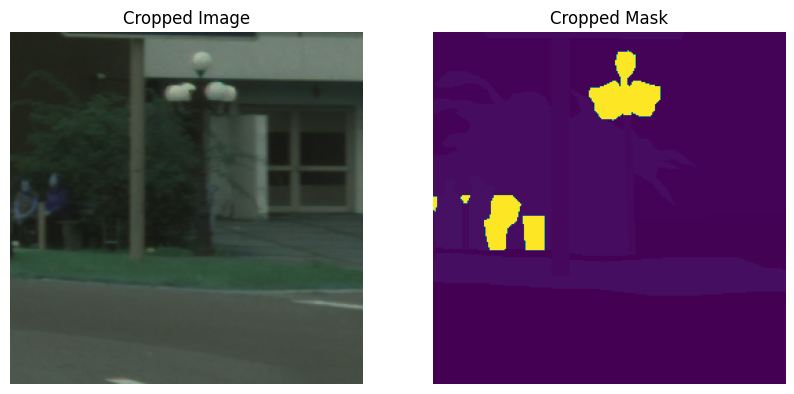

In [16]:
cropper = RandomCropper()
sample_cropped = cropper(sample)

cropped_image = sample_cropped['images']
cropped_mask = sample_cropped['masks']


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cropped_image)
plt.title('Cropped Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cropped_mask)
plt.title('Cropped Mask')
plt.axis('off')

plt.show()

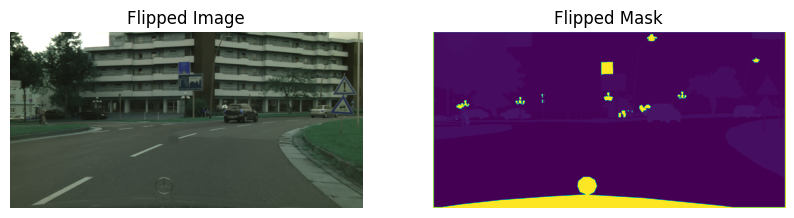

In [24]:

horizontal_flip = HorizontalFlip(['images', 'masks'])
sample_flipped = horizontal_flip(sample)

flipped_image = sample_flipped['images']
flipped_mask = sample_flipped['masks']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(flipped_image)
plt.title('Flipped Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(flipped_mask)
plt.title('Flipped Mask')
plt.axis('off')

plt.show()

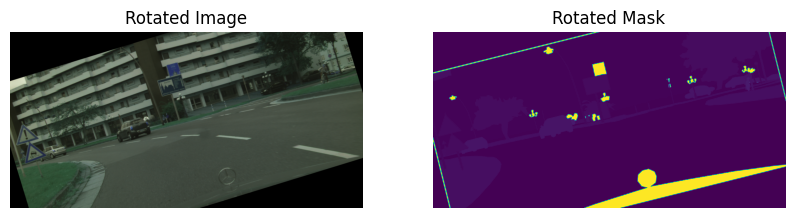

In [28]:

rotator = RandomRotator(['images', 'masks'])
sample_rotate = rotator(sample)

rotated_image = sample_rotate['images']
rotated_mask = sample_rotate['masks']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rotated_image)
plt.title('Rotated Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rotated_mask)
plt.title('Rotated Mask')
plt.axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


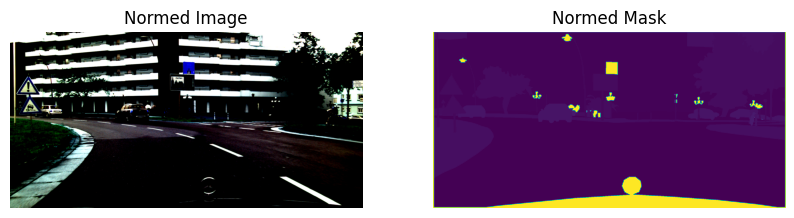

In [31]:

normalizer = ImageNormalizer(['images', 'masks'])
sample_norm = normalizer(sample)

norm_image = sample_norm['images']
norm_mask = sample_norm['masks']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(norm_image)
plt.title('Normed Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(norm_mask)
plt.title('Normed Mask')
plt.axis('off')

plt.show()

In [40]:
totensor = ToTensor(['images', 'masks'])
sample_tensor = totensor(sample)

tensor_image = sample_tensor['images']
tensor_mask = sample_tensor['masks']

In [41]:
print(tensor_image)

tensor([[[201, 206, 172],
         [201, 207, 174],
         [203, 208, 176],
         ...,
         [ 33,  44,  33],
         [ 33,  44,  33],
         [ 33,  44,  33]],

        [[199, 204, 172],
         [201, 206, 173],
         [203, 207, 174],
         ...,
         [ 35,  45,  34],
         [ 34,  45,  33],
         [ 34,  45,  33]],

        [[199, 204, 173],
         [200, 205, 174],
         [202, 206, 173],
         ...,
         [ 35,  45,  33],
         [ 35,  45,  33],
         [ 34,  45,  33]],

        ...,

        [[ 82,  99,  83],
         [ 81,  98,  82],
         [ 82,  98,  82],
         ...,
         [ 62,  70,  55],
         [ 61,  69,  53],
         [ 60,  68,  53]],

        [[ 82,  99,  83],
         [ 81,  98,  82],
         [ 82,  98,  82],
         ...,
         [ 64,  72,  56],
         [ 62,  71,  55],
         [ 60,  69,  53]],

        [[ 82,  99,  83],
         [ 81,  98,  82],
         [ 82,  98,  82],
         ...,
         [ 64,  71,  54],
        

In [109]:

from torchvision.transforms import Compose

Train_data_transform=Compose([
    ImageLoader( keys= ['images','masks'] ),
    RandomCropper(),
    HorizontalFlip( keys= ['images','masks'] ),
    RandomRotator(keys=['images', 'masks']),
    ImageNormalizer( keys= ['images'] ),
    ToTensor( keys= ['images','masks'] ),
    # OneHotEncodeLabels( keys= ['masks'] ),


])


Valid_data_transform=Compose([
    ImageLoader( keys= ['images','masks'] ),
    RandomCropper(),
    HorizontalFlip( keys= ['images','masks'] ),
    RandomRotator(keys=['images', 'masks']),
    ImageNormalizer( keys= ['images'] ),
    ToTensor( keys= ['images','masks'] ),
    # OneHotEncodeLabels( keys= ['masks'] ),
    

])

### Define the dataloader and dataset

In [110]:
import re
from torch.utils.data import DataLoader, Dataset
from typing import List

In [111]:
class CityScapes(Dataset):
    def __init__(self, input_dataframe: pd.DataFrame, root_dir: str, KeysOfInterest: List[str], data_transform:Compose):
        self.root_dir = root_dir
        self.koi = KeysOfInterest
        self.input_dataframe = input_dataframe[self.koi]
        self.data_transform=data_transform

    def __getitem__(self, item: int):
        sample = {}
        row = self.input_dataframe.iloc[item]
        for key in self.koi:
            sample[key] = row[key]
        if self.data_transform is not None:
            sample = self.data_transform(sample)
        return sample
        
    def __len__(self):
        return len(self.input_dataframe)

In [112]:
ds_train=CityScapes(input_dataframe=train_df,
                 root_dir="/app/duy55/segmentation/cityscapes",
                 KeysOfInterest=["images","masks"],
                 data_transform=Train_data_transform)

ds_val=CityScapes(input_dataframe=val_df,
                 root_dir="/app/duy55/segmentation/cityscapes",
                 KeysOfInterest=["images","masks"],
                 data_transform=Valid_data_transform)

In [113]:
test0=ds_train[0]

In [114]:
test0

{'images': tensor([[[-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2],
          ...,
          [-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2]],
 
         [[-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2],
          ...,
          [-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2]],
 
         [[-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2],
          ...,
          [-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2]],
 
         ...,
 
         [[-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2],
          ...,
          [-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2]],
 
         [[-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2],
          ...,
          [-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2]],
 
         [[-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2],
          ...,
          [-2, -2, -2],
          [-2, -2, -2],
          [-2, -2, -2]]]),
 '

In [117]:
dl_train=DataLoader(dataset=ds_train,batch_size= 20 ,num_workers=0 ,shuffle=True)
dl_val=DataLoader(dataset=ds_val,batch_size= 20 ,num_workers=0 ,shuffle=True)

In [118]:
for batch in dl_train:
    img = batch['images']
    label = batch['masks']   
    print(img.shape) 
    print(label.shape) 
    break

torch.Size([20, 256, 256, 3])
torch.Size([20, 256, 256])


In [119]:
for data in dl_train:
    image = data['images']
    labels = data['masks']
    print(image.shape)
    break

torch.Size([20, 256, 256, 3])
